# Use BlackJAX with TFP

BlackJAX can take any log-probability function as long as it is compatible with JAX's JIT. In this notebook we show how we can use tensorflow-probability as a modeling language and BlackJAX as an inference library.

We reproduce the Eight Schools example from the [TFP documentation](https://www.tensorflow.org/probability/examples/Eight_Schools) (all credit for the model goes to the TFP team). For this notebook to run you will need to install tfp-nightly:

```bash
pip install tfp-nightly
```

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

import blackjax

## Data

Please refer to the [original TFP example](https://www.tensorflow.org/probability/examples/Eight_Schools) for a description of the problem and the model that is used. This notebook focuses exclusively on the possibility to use TFP as a modeling language and BlackJAX as an inference library.

In [2]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32
)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32
)  # treatment SE

## Model

In [3]:
model = tfd.JointDistributionSequential(
    [
        tfd.Normal(loc=0.0, scale=10.0, name="avg_effect"),  # `mu` above
        tfd.Normal(loc=5.0, scale=1.0, name="avg_stddev"),  # `log(tau)` above
        tfd.Independent(
            tfd.Normal(
                loc=jnp.zeros(num_schools),
                scale=jnp.ones(num_schools),
                name="school_effects_standard",
            ),  # `theta_prime`
            reinterpreted_batch_ndims=1,
        ),
        lambda school_effects_standard, avg_stddev, avg_effect: (
            tfd.Independent(
                tfd.Normal(
                    loc=(
                        avg_effect[..., jnp.newaxis]
                        + jnp.exp(avg_stddev[..., jnp.newaxis])
                        * school_effects_standard
                    ),  # `theta` above
                    scale=treatment_stddevs,
                ),
                name="treatment_effects",  # `y` above
                reinterpreted_batch_ndims=1,
            )
        ),
    ]
)


def target_logprob_fn(avg_effect, avg_stddev, school_effects_standard):
    """Unnormalized target density as a function of states."""
    return model.log_prob(
        (avg_effect, avg_stddev, school_effects_standard, treatment_effects)
    )


logprob_fn = lambda x: target_logprob_fn(**x)

In [4]:
rng_key = jax.random.PRNGKey(0)
initial_position = {
    "avg_effect": jnp.zeros([]),
    "avg_stddev": jnp.zeros([]),
    "school_effects_standard": jnp.ones([num_schools]),
}

Let us first run the window adaptation to find a good value for the step size and for the inverse mass matrix. As in the original example we will run the integrator 3 times at each step.

In [5]:
%%time

adapt = blackjax.window_adaptation(
    blackjax.hmc, logprob_fn, 1000, num_integration_steps=3
)

last_state, kernel, _ = adapt.run(rng_key, initial_position)

CPU times: user 2.56 s, sys: 5.72 ms, total: 2.57 s
Wall time: 2.54 s


BlackJAX does not come with an inference loop (yet) so you have to implement it yourself, which just takes a few lines with JAX:

In [6]:
%%time


def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos


# Sample from the posterior distribution
states, infos = inference_loop(rng_key, kernel, last_state, 500_000)
states.position["avg_effect"].block_until_ready()

CPU times: user 1.55 s, sys: 39 ms, total: 1.59 s
Wall time: 1.55 s


DeviceArray([ 9.266757 , 14.293715 ,  6.9787436, ..., -4.236508 ,
              2.6391485,  4.2122736], dtype=float32)

Extra information about the inference is contained in the `infos` namedtuple. Let us compute the average acceptance rate:

In [7]:
acceptance_rate = np.mean(infos.acceptance_probability)
print(f"Acceptance rate: {acceptance_rate:.2f}")

Acceptance rate: 0.94


The samples are contained as a dictionnary in `states.position`. Let us compute the posterior of the school treatment effect:

In [8]:
samples = states.position
school_effects_samples = (
    samples["avg_effect"][:, np.newaxis]
    + np.exp(samples["avg_stddev"])[:, np.newaxis] * samples["school_effects_standard"]
)

And now let us plot the correponding chains and distributions:

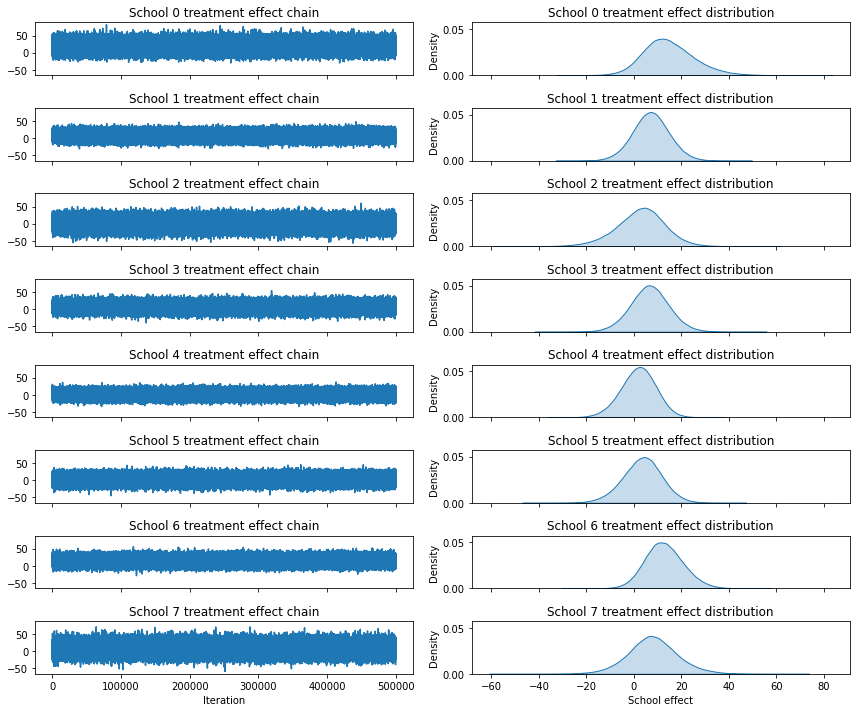

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axes = plt.subplots(8, 2, sharex="col", sharey="col")
fig.set_size_inches(12, 10)
for i in range(num_schools):
    axes[i][0].plot(school_effects_samples[:, i])
    axes[i][0].title.set_text(f"School {i} treatment effect chain")
    sns.kdeplot(school_effects_samples[:, i], ax=axes[i][1], shade=True)
    axes[i][1].title.set_text(f"School {i} treatment effect distribution")
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

## Compare sampling time with TFP

In [10]:
import tensorflow.compat.v2 as tf

tf.enable_v2_behavior()

In [11]:
%%time

num_results = 500_000
num_burnin_steps = 0

# Improve performance by tracing the sampler using `tf.function`
# and compiling it using XLA.
@tf.function(autograph=False, experimental_compile=True, experimental_relax_shapes=True)
def do_sampling():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            jnp.zeros([]),
            jnp.zeros([]),
            jnp.ones([num_schools]),
        ],
        kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_logprob_fn, step_size=0.4, num_leapfrog_steps=3
        ),
        seed=rng_key,
    )


states, kernel_results = do_sampling()

/home/remi/.virtualenvs/blackjax/lib/python3.9/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 3.4 s, sys: 598 ms, total: 4 s
Wall time: 3.97 s
